![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Suitability of satellite sea ice concentration products for assessment of the effect of climate change on sea ice
Production date: 31-05-2024

Produced by: Nansen Environmental and Remote Sensing Center. Timothy Williams.

## 🌍 Use case: Assessing the effect of climate change on sea ice using satellite sea ice concentration products

## ❓ Quality assessment question
- **Can we see the effect of climate change using satellite sea ice concentration products?**
- **What are the limitations of using these products for this purpose?**

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
- The Arctic sea ice extent shows a clear downward trend in the 1979-2020 period covered by the SSMIS (Special Sensor Microwave Imager/Sounder) CDR (Climate Data Record). The minimum extent shows a greater drop (3.5 million km$^2$) than the maximum extent (2.5 million km$^2$), although the maximum has a steadier drop. The patterns in the extents are consistent with those seen in the AMSR (Advanced Microwave Scanning Radiometer) CDR over its lifetime (2002-2017). The minimum extent increases again in 2021 before starting to drop again.

- On the other hand, the Antarctic sea ice minima and maxima in extent show an upward trend in the 1979-2015 period, although there is quite a lot of spread in these values. After 2015, the SSMIS and the AMSR CDRs both show a significant drop, with 2017 having notably a low minimum in extent, and other years also having minima much lower than the 2015 minimum. The drop seems to continue into the period covered by the SSMIS ICDR (2021-2024), but there is still a lot of fluctuation and the shorter time interval of 2015-2024 makes it difficult to draw any conclusion about this.

- There have been large drops in minimum and maximum sea ice extent in the years covered by the SSMIS ICDR product (2021-2024). While this raises a question of whether these changes are physical or due to discontinuities in the product as we change from the SSMIS CDR to the ICDR, the previous version of the ICDR (version 2, covering 2016-2023) is consistent with both the latest version of the CDR (version 3) in the period 2016-2020 and version 3 of the ICDR in 2020-2023, so we can be reasonably confident that the changes are physical.

- This data is better suited for large-scale studies (as opposed to very localised regional studies) due to the relatively large footprints of passive microwave sensors. The output grid resolution is 10km, but the footprint may be up to ten times larger, depending on the frequency used and the size of the satellite antennae. The ESA CCI products use AMSR (Advanced Microwave Scanning Radiometer) sensors with larger antennae so have higher effective resolution than the EUMETSAT OSI SAF CDR and ICDR. However, they also tend to be a bit noisier and more affected by atmospheric conditions ([<span style="color:blue">Ivanova et al, 2015</span>](https://doi.org/10.5194/tc-9-1797-2015)). Moreover, users should avoid relying too much on the grid-cell by grid-cell values of sea ice concentration (SIC), which have quite high uncertainty. Instead they should rather consider integrated quantities like extent or area calculated over a large area.

```

## 📋 Methodology
We use version 3 of the [<span style="color:blue">sea ice concentration dataset</span>](https://cds.climate.copernicus.eu/datasets/satellite-sea-ice-concentration?tab=overview), which has three products from EUMETSAT (European Organisation for the Exploitation of Meteorological Satellites) OSI SAF (Ocean and Sea Ice Satellite Applications Facility):
- SSMIS CDR (1979-2020)
- SSMIS ICDR (2021-2024)
- AMSR CDR (2003-2017)

For each product, we create time series of the sea ice extent, defined as the area of grid cells with SIC > 15%, which is typically taken as the lowest SIC that passive microwave sensors can detect. The seasonal cycles are plotted by year to see if it is changing with time. Time series of the yearly minima and maxima in extent are also computed and plotted.

Sea ice area is another integrated quantity that is commonly used with SIC products. It is defined as the total ice-covered area (the sum of SIC multiplied by the grid cell area). However, given the uncertainties in the actual values of SIC in passive microwave products ([<span style="color:blue">Ivanova et al, 2015</span>](https://doi.org/10.5194/tc-9-1797-2015); [<span style="color:blue">Comiso et al, 1997</span>](https://doi.org/10.1016/S0034-4257(96)00220-9); [<span style="color:blue">Buckley et al, 2024</span>](https://doi.org/10.5194/egusphere-2024-3861)) this is less accurate than extent, so we do not present statistics of area here. Moreover, we found it followed the same seasonal cycle as extent, and was about 2 million km$^2$ lower than the extent in the Arctic, and about
4.5 - 5 million km$^2$ lower in the Antarctic, so it added little extra information.

The "Analysis and results" section is structured as follows:

**[](satellite_satellite-sea-ice-concentration_climate-impact-indicators_q01:section-1)**

**[](satellite_satellite-sea-ice-concentration_climate-impact-indicators_q01:section-2)**

**[](satellite_satellite-sea-ice-concentration_climate-impact-indicators_q01:section-3)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**[](satellite_satellite-sea-ice-concentration_climate-impact-indicators_q01:section-3.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**[](satellite_satellite-sea-ice-concentration_climate-impact-indicators_q01:section-3.2)**

## 📈 Analysis and results

(satellite_satellite-sea-ice-concentration_climate-impact-indicators_q01:section-1)=
### 1. Parameters, requests and functions definition
- Define parameters and formulate requests for downloading with the EQC toolbox.
- Define functions to be applied to process and reduce the size of the downloaded data.
- Define functions to post-process and visualize the data.

#### 1.1 Import libraries
Import the required libraries, including the EQC toolbox.

In [1]:
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-notebook")
warnings.filterwarnings("ignore", module="cf_xarray")

In [2]:
import os
os.environ["CDSAPI_RC"] = "/data/wp5/williams_timothy/.cdsapirc"

#### 1.2 Set parameters
Set the time period to cover with `start_year` and `stop_year`.
Also specify `sic_threshold` - a grid cell is considered ice-covered if its concentration value (in %) exceeds this value. `extent_range` sets the plot range for the extent.

In [3]:
# Time
start_year = 1979
stop_year = 2024

# Conc threshold for calculating extent [%]
sic_threshold = 15

# range of sea ice extent for Arctic and Antarctic [10^6 km^2]
extent_range = {
    "northern_hemisphere": [3, 17.5],
    "southern_hemisphere": [1.5, 22],
}

#### 1.3 Define requests
Define the requests for downloading the sea ice concentration data using the EQC toolbox.

In [4]:
collection_id = 'satellite-sea-ice-concentration'

conc_request = {
    "origin": "eumetsat_osi_saf",
    "cdr_type": "cdr",
    "variable": "all",
    "version": "v3",
    "temporal_aggregation": "daily",
}

request_dict = {
    # SSMIS CDR
    "SSMIS (CDR)": download.update_request_date(
       conc_request | {"sensor": "ssmis"},
       start=f"{max(start_year, 1979)}-01",
       stop=f"{min(stop_year, 2020)}-12",
       stringify_dates=True,
    ),
    # SSMIS ICDR
    "SSMIS (ICDR)": download.update_request_date(
        conc_request | {"sensor": "ssmis", "cdr_type": "icdr"},
        start=f"{max(start_year, 2021)}-01",
        stop=f"{min(stop_year, 2024)}-12",
        stringify_dates=True,
    ),
    # only CDR available for ESA-CCI
    "AMSR (CDR)": download.update_request_date(
        conc_request | {"sensor": "amsr"},
        start=f"{max(start_year, 2002)}-01",
        stop=f"{min(stop_year, 2017)}-12",
        stringify_dates=True,
    ),
}

#### 1.4 Define function to cache
- `compute_siconc_time_series` computes the extent, area, and the RMS error from a given sea ice concentration product.

In [5]:
def compute_siconc_time_series(ds, sic_threshold):
    ds = ds.convert_calendar("standard", align_on="date")

    # grid cell area of sea ice edge grid
    dims = ("xc", "yc")
    dx = np.abs(np.diff(ds[dims[0]][:2].values))[0]
    grid_cell_area = (dx ** 2) * 1.0e-6  # 10^6 km2

    # get sea ice concentration and convert to ice/water classification
    sic = ds.cf["sea_ice_area_fraction"]
    sic_error = ds.cf["sea_ice_area_fraction standard_error"]
    if sic.attrs.get("units", "") == "(0 - 1)":
        sic *= 100
        sic_error *= 100

    # compute extent
    dataarrays = {}
    sic_class = xr.where(sic >= sic_threshold, 2, 1) # 1 = open water, 2 = ice
    dataarrays["extent"] = grid_cell_area * (sic_class - 1).sum(dim=dims)
    dataarrays["extent"].attrs = {
        "standard_name": "sea_ice_extent",
        "units": "$10^6$km$^2$",
        "long_name": "Sea ice extent",
    }

    # compute area
    dataarrays["area"] = grid_cell_area * .01 * sic.sum(dim=dims)
    dataarrays["area"].attrs = {
        "standard_name": "sea_ice_area",
        "units": "$10^6$km$^2$",
        "long_name": "Sea ice area",
    }

    # compute RMS error
    dataarrays["rms_error"] = np.sqrt((sic_error ** 2).mean(dim=dims))
    dataarrays["rms_error"].attrs = {
        "standard_name": "root_mean_square sea_ice_area_fraction standard_error",
        "units": "$10^6$km$^2$",
        "long_name": "Root mean square sea ice area fraction standard error",
    }

    return xr.Dataset(dataarrays)

#### 1.5 Functions to make time series plots against day of year
- `rearrange_year_vs_dayofyear` changes the dataset from having a single time dimension to having two: the year and the Julian day of the year.
- `make_subplot` makes one plot of a variable with a different line for each year (shown with a colorbar), and with the $x$ axis being the Julian day of the year.
- `plot_against_dayofyear` calls `make_subplot` for each of extent and area.

In [6]:
def rearrange_year_vs_dayofyear(ds):
    new_dims = ("year", "dayofyear")
    ds = ds.convert_calendar("noleap")
    ds = ds.assign_coords(
        {dim: ("time", getattr(ds["time"].dt, dim).values) for dim in new_dims}
    )
    return ds.set_index(time=new_dims).unstack("time")


def make_subplot(ax, ds_doy, vname, color_map):
    num_years = len(ds_doy.year)
    for i,year in enumerate(ds_doy.year):
        da = ds_doy.sel(year=year)[vname].squeeze()
        ax.plot(da.dayofyear, da.values, color=color_map(i/(num_years-1)), label=year.item())


def plot_against_dayofyear(ds, varname="extent", years_per_plot=4, ncols=4, figsize=(15,6), ylim=None):
    da = ds[varname]
    ny = len(da["year"])
    nax = int(np.ceil(ny / years_per_plot)) # number of subplots
    nrows = int(np.ceil(nax / ncols)) # number of rows
    fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=figsize)
    for i, year in enumerate(da["year"]):
        iax = i // years_per_plot
        ax = axs.flatten()[iax]
        arr = da.sel(year=year).values
        gpi = np.isfinite(arr)
        x = da["dayofyear"][gpi]
        ax.plot(x, arr[gpi], label=str(year.values))
        if i % years_per_plot == years_per_plot - 1:
            ax.legend()

    if ylim is not None:
        ax.set_ylim(ylim)
    ax.legend()

    for i in range(nax, nrows * ncols):
        axs.flatten()[i].set_visible(False)

    for ax in axs[:,0] if nrows > 1 else axs[:1]:
        ax.set_ylabel(f"{varname.capitalize()} [{da.units}]")

    for ax in axs[-1,:] if nrows > 1 else axs:
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
        ax.xaxis.set_tick_params(rotation=45)

#### 1.6 Functions to make time series plots of yearly minima and maxima
- `full_year_only_resample` gets an extremum (maximum or minimum) of extent and area for each year.
- `get_yearly_min_max` calls `full_year_only_resample` and does some post-processing to give clearer variable names and attributes for the extrema.
- `plot_yearly_extremes` plots the values for a set of extrema for a given region against the year.

In [7]:
def full_year_only_resample(ds, reduction, sel_dict=None):
    """
    Calculate yearly reduction eg to get the yearly min or max of a time series
    
    Parameters
    ----------
    ds : xr.Dataset
    reduction : str
        eg min or max

    Returns
    -------
    ds_reduced : xr.Dataset
        resampled time series
    """
    if sel_dict:
        ds = ds.sel(sel_dict)
    year_mask = ds["time"].resample(time="YE").count() > 150
    return getattr(ds.resample(time="YE"), reduction)(), year_mask


def get_yearly_min_max(ds, **kwargs):
    ds1 = ds.drop_vars(["rms_error"])
    data = {}
    for reduction in ["min", "max"]:
        ds2, year_mask = full_year_only_resample(ds1, reduction, **kwargs)
        data["year_mask"] = xr.DataArray(
            year_mask.values, coords={"year": ds2.time.dt.year.values},
            attrs={"description": "True if year has sufficient observations"})
        for var_name in ds2.data_vars:
            da = ds2[var_name]
            atts = da.attrs
            atts["standard_name"] = f"{reduction}_{atts['standard_name']}"
            atts["long_name"] = f"{reduction.capitalize()}imum {atts['long_name'][0].lower()}{atts['long_name'][1:]}"
            data[f"{reduction}_{var_name}"] = xr.DataArray(
                da.values, attrs=atts, coords={"year": ds2.time.dt.year.values, "region": ds2.region.values})
    return xr.Dataset(data)


def plot_yearly_extremes(datasets, region="northern_hemisphere", var_name="min_extent"):
    fig, ax = plt.subplots(1, 1)
    for product, ds in datasets.items():
        year_mask = ds["year_mask"]
        if product == "AMSR (CDR)":
            if var_name == "min_extent":
                # make sure 2012 record Arctic minimum is included (exclude Antarctic minimum)
                year_mask[ds.year.values == 2012] = (region == "northern_hemisphere")
                # exclude Antarctic minimum in 2002
                year_mask[ds.year.values == 2002] = (region == "northern_hemisphere")
                # include Antarctic minimum in 2017
                year_mask[ds.year.values == 2017] = (region == "southern_hemisphere")

            if var_name == "max_extent":
                # include Arctic maximum in 2017
                year_mask[ds.year.values == 2017] = (region == "northern_hemisphere")
                # make sure 2012 Antarctic maximum is included (exclude Arctic maximum)
                year_mask[ds.year.values == 2012] = (region == "southern_hemisphere")
                # exclude Arctic maximum in 2002
                year_mask[ds.year.values == 2002] = (region == "southern_hemisphere")

        if product == "SSMIS (ICDR)":
            if var_name == "min_extent":
                # make sure 2024 Antarctic minimum is included (exclude Arctic minimum)
                year_mask[ds.year.values == 2024] = (region == "southern_hemisphere")

            if var_name == "max_extent":
                # include Arctic maximum in 2024 (exclude Antarctic maximum)
                year_mask[ds.year.values == 2024] = (region == "northern_hemisphere")

        ds2 = ds.sel(region=region).where(year_mask, drop=True)
        da = ds2[var_name]
        kw_plot = dict(label=product, alpha=.75)
        if product == "SSMIS (ICDR v2)":
            kw_plot["zorder"] = 0
        ax.plot(da.year, da.values, '^-', **kw_plot)
    ax.set_ylabel(f"{da.attrs['long_name']} [{da.attrs['units']}]")
    ax.set_xlabel(f"Year")
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(axis='x', which='minor', top=False)
    ax.grid(axis='x', which='both', linestyle=':')
    ax.grid(axis='y', which='both', linestyle=':')

    _ = ax.legend()

(satellite_satellite-sea-ice-concentration_climate-impact-indicators_q01:section-2)=
### 2. Download and transform
This is where the data is downloaded, transformed with `compute_siconc_time_series`, and saved to disk by the EQC toolbox. If the code is rerun the transformed data is loaded from the disk.
For plotting, it is then post-processed with either `rearrange_year_vs_dayofyear` (to be used by `plot_against_dayofyear`) or `get_yearly_min_max` (to be used by `plot_yearly_extremes`).

In [ ]:
download_kwargs = {
    "drop_variables": (
        "raw_ice_conc_values",
        "smearing_standard_error",
        "algorithm_standard_error",
        "status_flag",
    ),
}

datasets_diagnostics = {}
datasets = []
for product, requests in request_dict.items():
    for region in [
        "northern_hemisphere",
        "southern_hemisphere",
    ]:
        print(f"{product = }, {region = }")
        regional_requests = [request | {"region": region} for request in requests]
        ds = download.download_and_transform(
            collection_id, regional_requests,
            transform_func=compute_siconc_time_series,
            transform_func_kwargs={"sic_threshold": sic_threshold},
            chunks={"year": 1},
            **download_kwargs,
        )
        datasets.append(ds.expand_dims(region=[region]).compute())
    datasets_diagnostics[product] = xr.concat(datasets, "region")
    datasets = []

# post-process for plotting
datasets_diagnostics_rearranged = {}
datasets_diagnostics_minmax = {}
for product in request_dict:
    datasets_diagnostics_rearranged[product] = rearrange_year_vs_dayofyear(datasets_diagnostics[product])
    datasets_diagnostics_minmax[product] = get_yearly_min_max(datasets_diagnostics[product])

(satellite_satellite-sea-ice-concentration_climate-impact-indicators_q01:section-3)=
### 3. Results

(satellite_satellite-sea-ice-concentration_climate-impact-indicators_q01:section-3.1)=
#### 3.1 Arctic sea ice

Below we plot the daily Arctic sea ice extent from 1979 to 2020 from the CDR product using the SSMIS sensor. This is the product spanning the longest period. Clearly later years have lower extent than earlier ones with 2012 having the lowest minimum extent in this period. Other years with low minimum extents are 2007, 2016, 2019 and 2020. The minimum (September) extents show a much wider spread than those at other times of the year.

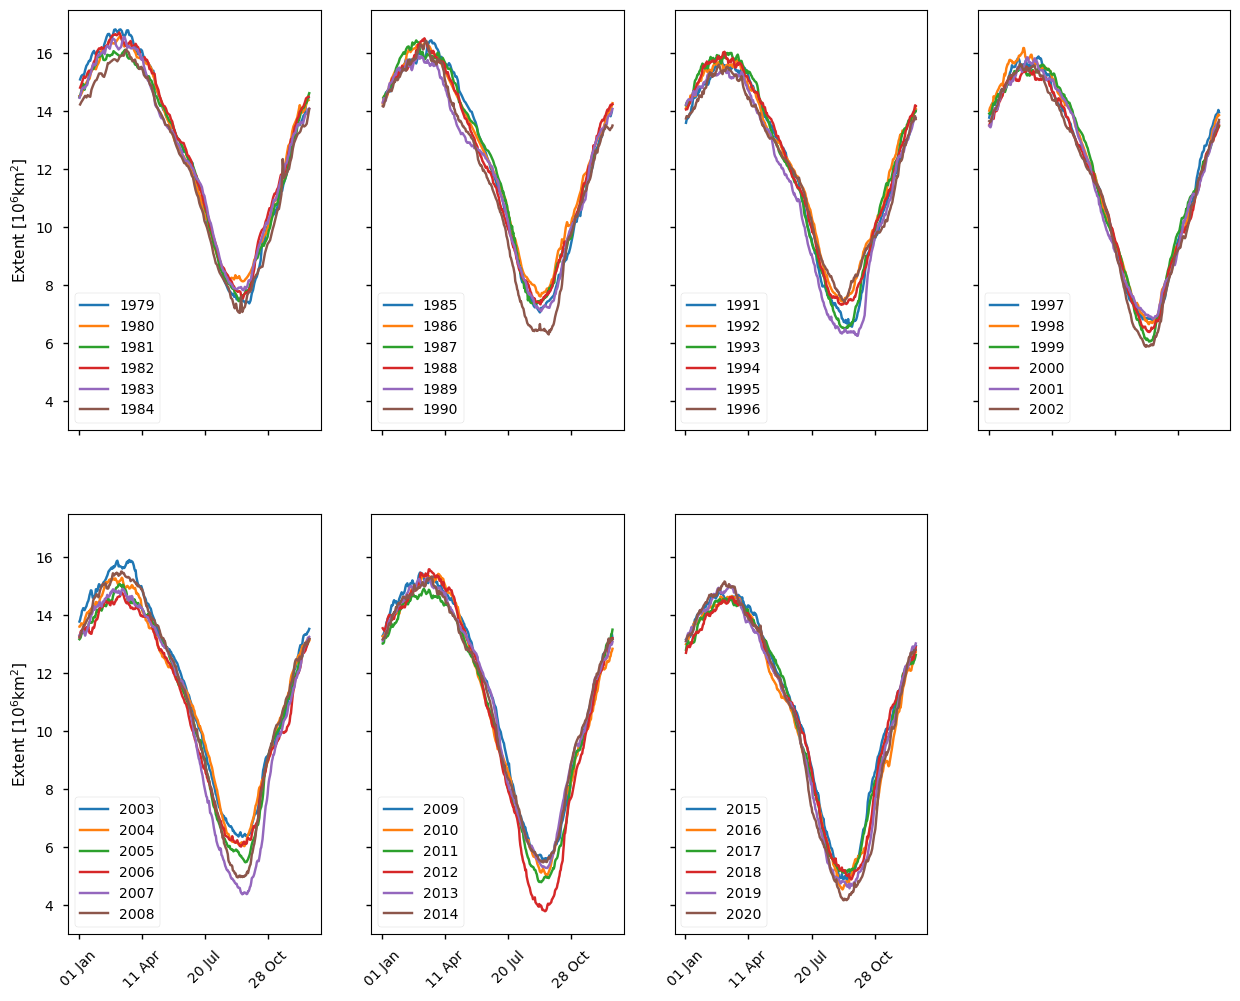

In [9]:
plot_against_dayofyear(datasets_diagnostics_rearranged["SSMIS (CDR)"].sel(region="northern_hemisphere"), years_per_plot=6, figsize=(15,12), ylim=extent_range["northern_hemisphere"])

Below we plot the daily Arctic sea ice extent from 2021 to 2024 from the ICDR product, which also uses the SSMIS sensor. This is the product spanning the shortest period but there is a clear downward trend in the minimum extents. The latest complete year for this period, 2023, has the lowest maximum and minimum. However the 2024 maximum is higher than the 2023 maximum.

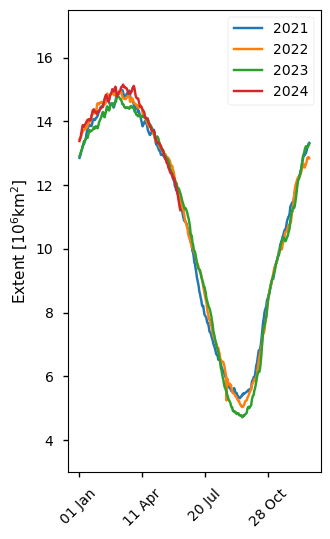

In [10]:
plot_against_dayofyear(datasets_diagnostics_rearranged["SSMIS (ICDR)"].sel(region="northern_hemisphere"), ylim=extent_range["northern_hemisphere"])

Below we plot the daily Arctic sea ice extent from 2002 to 2017 from the CDR product using the AMSR sensor. As with the SSMIS CDR earlier years generally
have higher extents. Again the year with the lowest minima in this product is 2012, with 2007 and 2016 being notable lows. The years 2015-2017 have the three lowest maxima, with 2006 and 2007 having the next lowest maxima.

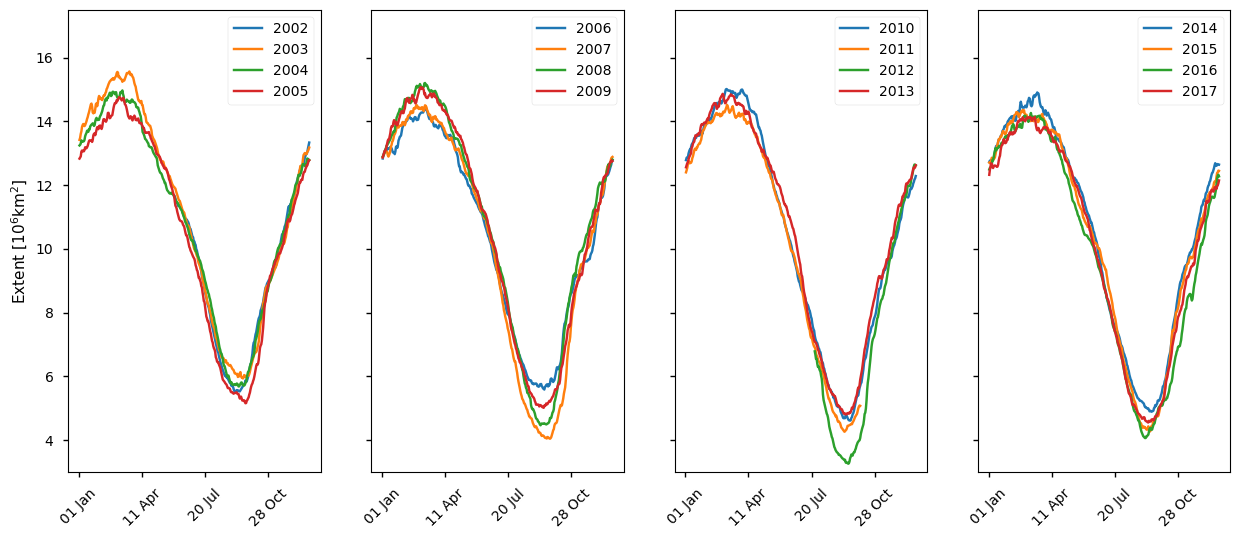

In [11]:
plot_against_dayofyear(datasets_diagnostics_rearranged["AMSR (CDR)"].sel(region="northern_hemisphere"), ylim=extent_range["northern_hemisphere"])

Below we plot the Arctic yearly minima in extent for all the products. There is a clear downward trend in the SSMIS CDR product, which spans the longest period. The drop is about 3 million km$^2$ over the 25-year period from 1995 to 2020. There is a slower drop in the previous years, but it is less clear. This product has higher values than the AMSR CDR product illustrating the possible magnitude of the uncertainty in the products, which could be around 0.5 million km$^2$. There is quite a large jump at the transition year between the SSMIS CDR and ICDR products which raises the question of whether the jump is physical or a result in a disontinuity in the products. However, in results not shown we have also checked these results against version 2 of the SSMIS ICDR product which covered 2016-2023, so we can be reasonably confident in the latest ICDR results.

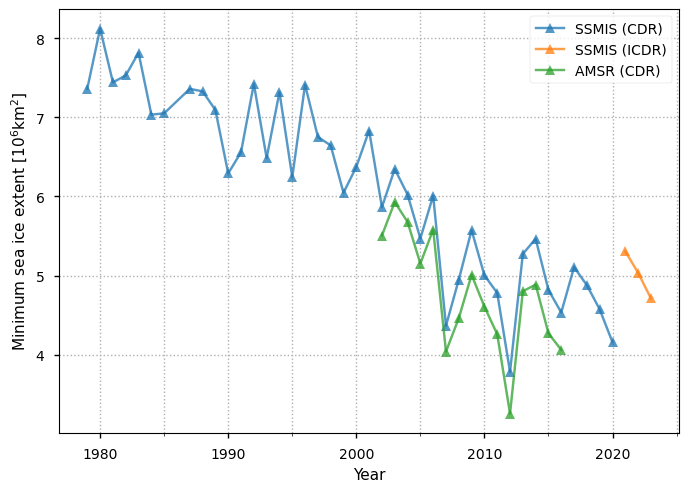

In [12]:
plot_yearly_extremes(datasets_diagnostics_minmax, var_name="min_extent")

Below we plot the Arctic yearly maxima in extent for all the products. There is a clear downward trend in the SSMIS CDR and ICDR products, which together span the full period. The drop is about 2 million km$^2$ over the 44-year period from 1979 to 2024, which while lower than for the yearly minima is more steady. The SSMIS products again have higher values than the AMSR product, again by around 0.5 million km$^2$. Note that notably low sea ice minima (eg 2007, 2012) are preceded by notably low maxima (eg 2006, 2011).

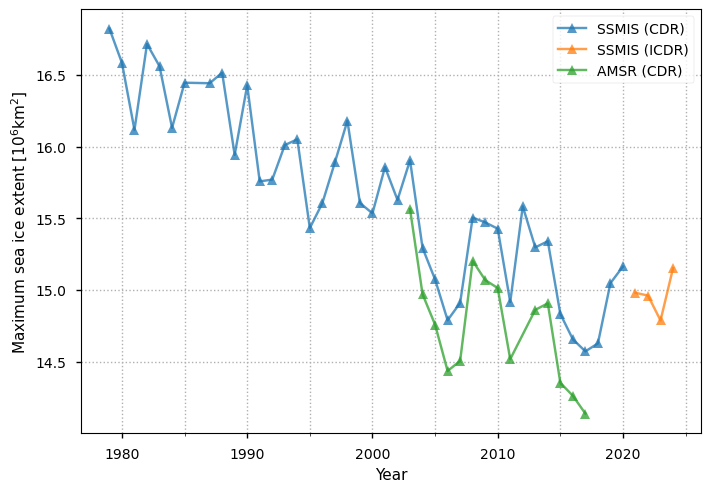

In [13]:
plot_yearly_extremes(datasets_diagnostics_minmax, var_name="max_extent")

(satellite_satellite-sea-ice-concentration_climate-impact-indicators_q01:section-3.2)=
#### 3.2 Antarctic sea ice

Below we plot the daily Antarctic sea ice extent from 1979 to 2020 from the SSMIS CDR product. This is the product spanning the longest period. The progression with year is not as clear as for the Arctic, but the minimum extents after 2015 are clearly grouped much lower than the 2015 minimum extent. Unlike the Arctic, which had a higher spread around September, the spread of the extents is similar throughout the year.

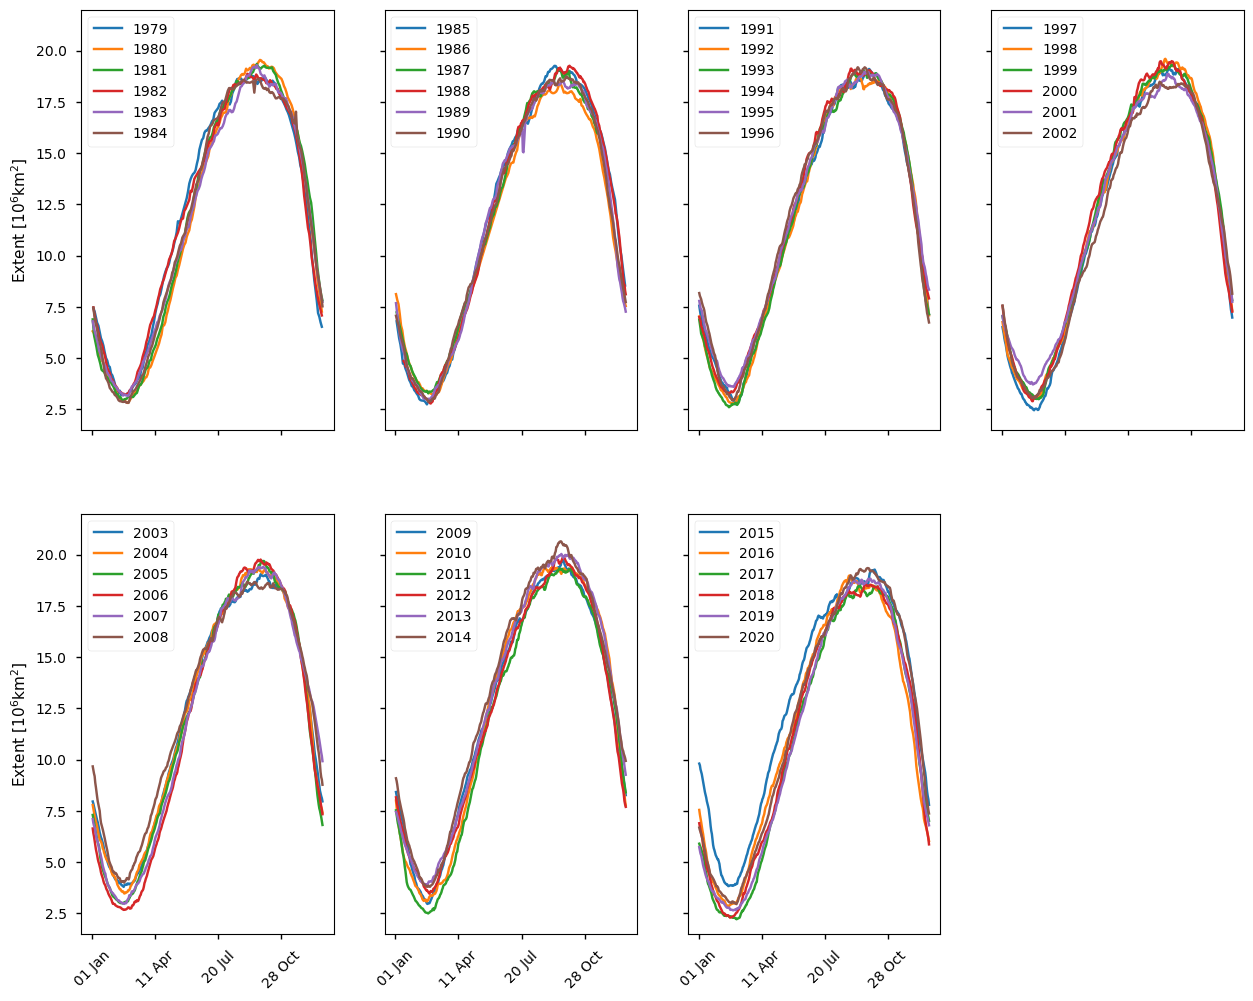

In [14]:
plot_against_dayofyear(datasets_diagnostics_rearranged["SSMIS (CDR)"].sel(region='southern_hemisphere'), years_per_plot=6, figsize=(15,12), ylim=extent_range["southern_hemisphere"])

Below we plot the daily Antarctic sea ice extent from 2021 to 2024 from the SSMIS ICDR product. This is the product spanning the shortest period but there is a clear downward trend in the maximum extents. The later years (2022-204) have similarly low minimum extents.

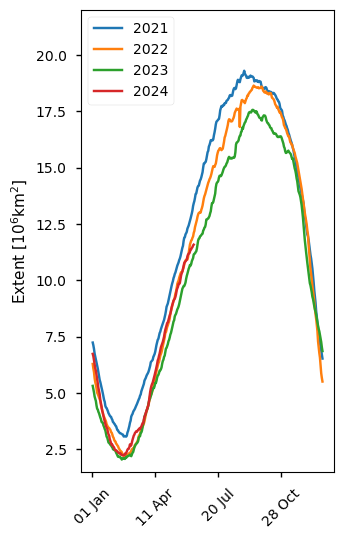

In [15]:
plot_against_dayofyear(datasets_diagnostics_rearranged["SSMIS (ICDR)"].sel(region='southern_hemisphere'), ylim=extent_range["southern_hemisphere"])

Below we plot the daily Antarctic sea ice extent from 2002 to 2017 from the AMSR CDR product. This product has a bit more spread around the time of the sea ice minimum (February) compared to the rest of the year. The year with the lowest minimum is 2017.

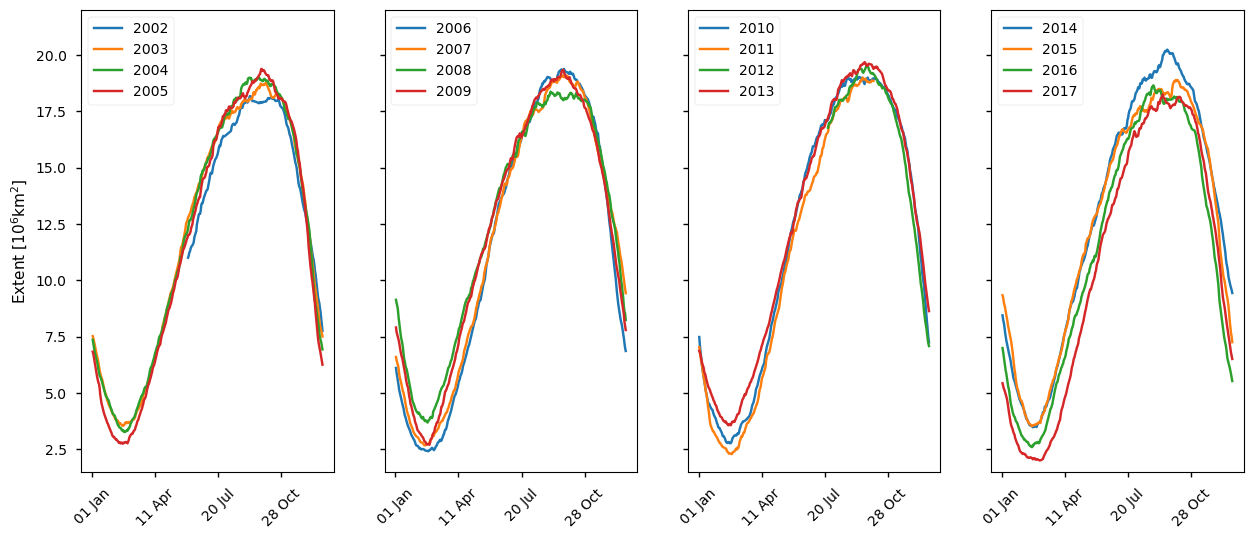

In [16]:
plot_against_dayofyear(datasets_diagnostics_rearranged["AMSR (CDR)"].sel(region='southern_hemisphere'), ylim=extent_range["southern_hemisphere"])

Below we plot the Antarctic yearly minima in extent for all the products. There is quite a spread and there seems to be a moderate upward trend up to 2015. However there is a sharp drop in both the AMSR and SSMIS CDR products after 2015. Although it climbs again in the few years after 2017, the SSMIS ICDR shows that it drops again after 2021. Since version 2 of the SSMIS ICDR also shows this drop, we can be reasonably confident that it is a physical effect and not just due to the change from CDR to ICDR.

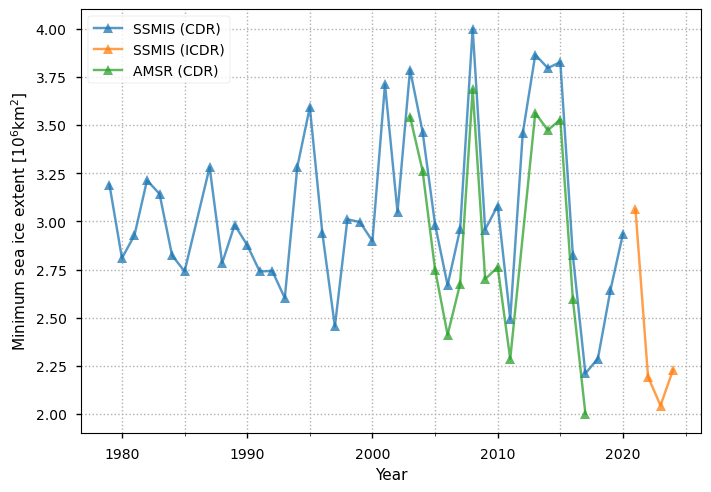

In [17]:
plot_yearly_extremes(datasets_diagnostics_minmax, region="southern_hemisphere", var_name="min_extent")

Below we plot the Antarctic yearly maxima in extent for all the products. There is less spread than for the minima, and it is stable up to about 2000. After then there also seems to be a moderate upward trend up to about 2015, but as the with the minimum extents, the maxima after 2015 are much lower. The SSMIS ICDR product again has much lower maximum extents, and since version 2 of the SSMIS ICDR also shows this drop, we can be reasonably confident that it is a physical effect and not just due to the change from CDR to ICDR.

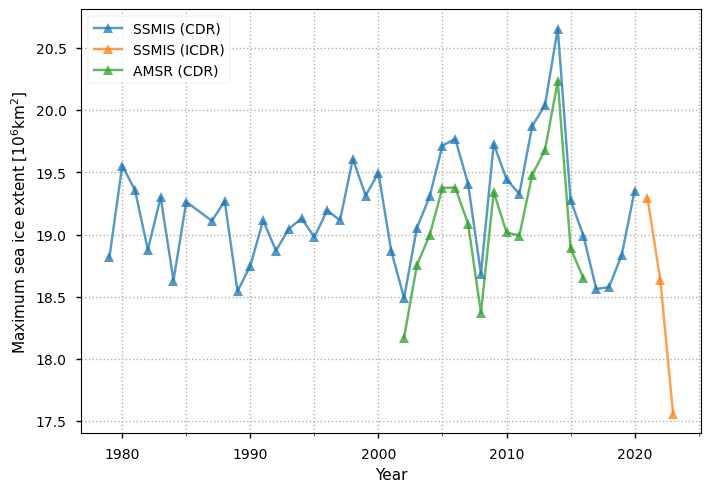

In [18]:
plot_yearly_extremes(datasets_diagnostics_minmax, region="southern_hemisphere", var_name="max_extent")

## ℹ️ If you want to know more

### Key resources

Introductory sea ice materials:
- [<span style="color:blue">Role of sea ice in the climate</span>](https://www.epa.gov/climate-indicators/climate-change-indicators-arctic-sea-ice)
- [<span style="color:blue">Observing sea ice with satellites</span>](https://www.metoffice.gov.uk/research/climate/cryosphere-oceans/sea-ice/measure)

Code libraries used:
* [<span style="color:blue">C3S EQC custom functions</span>](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/).

### References

1. Ivanova, N., Pedersen, L. T., Tonboe, R. T., Kern, S., Heygster, G., Lavergne, T., Sørensen, A., Saldo, R., Dybkjær, G., Brucker, L., & Shokr, M. (2015). Inter-comparison and evaluation of sea ice algorithms: towards further identification of challenges and optimal approach using passive microwave observations. The Cryosphere, 9(5), 1797-1817, [<span style="color:blue">https://doi.org/10.5194/tc-9-1797-2015</span>](https://doi.org/10.5194/tc-9-1797-2015).

2. Comiso, J. C., Cavalieri, D. J., Parkinson, C. L., & Gloersen, P. (1997). Passive microwave algorithms for sea ice concentration: A comparison of two techniques. Remote sensing of Environment, 60(3), 357-384, [<span style="color:blue">https://doi.org/10.1016/S0034-4257(96)00220-9</span>](https://doi.org/10.1016/S0034-4257(96)00220-9).

3. Buckley, E. M., Horvat, C., & Yoosiri, P. (2024). Sea Ice Concentration Estimates from ICESat-2 Linear Ice Fraction. Part 1: Multi-sensor Comparison of Sea Ice Concentration Products. EGUsphere, 2024, 1-19, [<span style="color:blue">https://doi.org/10.5194/egusphere-2024-3861</span>](https://doi.org/10.5194/egusphere-2024-3861).